# ❄️ 1. Exploratory Data Analysis ❄️
Data: Diabetes Dataset  
  
A valuable resource for researchers, data scientists, and medical professionals interested in the field of diabetes risk assessment and prediction. This dataset contains a diverse range of health-related attributes, meticulously collected to aid in the development of predictive models for identifying individuals at risk of diabetes.
  
Source: https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes 
  
Columns:  
 * Id: Unique identifier for each data entry.  
 * Pregnancies: Number of times pregnant.  
 * Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test.  
 * BloodPressure: Diastolic blood pressure (mm Hg).  
 * SkinThickness: Triceps skinfold thickness (mm).  
 * Insulin: 2-Hour serum insulin (mu U/ml).  
 * BMI: Body mass index (weight in kg / height in m^2).  
 * DiabetesPedigreeFunction: Diabetes pedigree function, a genetic score of diabetes.  
 * Age: Age in years.  
 * Outcome: Binary classification indicating the presence (1) or absence (0) of diabetes.  
  


# 2. Instantiate Analysis

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.types import StructType, StructField, FloatType, StringType, IntegerType
import snowflake.snowpark.functions as F

# data science libs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# misc
import json

### Make Snowpark Connection

In [2]:
# Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : VCHUNG
Role                        : "ACCOUNTADMIN"
Database                    : "DEMO_DATASCIENCE"
Schema                      : "SILVER"
Warehouse                   : "DEMO_COMPUTE_XSMALL"
Snowflake version           : 8.20.0
Snowpark for Python version : 1.11.1


### Read from Bronze 

Database: DEMO_DATASCIENCE  
Schema: BRONZE  
Table: RAW_DIABETES  

For more information on loading data, see documentation on [snowflake.snowpark.DataFrameReader](https://docs.snowflake.com/ko/developer-guide/snowpark/reference/python/api/snowflake.snowpark.DataFrameReader.html).




In [3]:
# Create labels for data location
databaseName = 'DEMO_DATASCIENCE'
schemaName = 'BRONZE'
tableName = 'RAW_DIABETES'
location = f'{databaseName}.{schemaName}.{tableName}'

# Query Dataframe
dataframe = session.table(location)

dataframe.show()
dataframe.dtypes

---------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"PREGNANCIES"  |"GLUCOSE"  |"BLOODPRESSURE"  |"SKINTHICKNESS"  |"INSULIN"  |"BMI"  |"DIABETESPEDIGREEFUNCTION"  |"AGE"  |"OUTCOME"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|1     |6              |148        |72               |35               |0          |33.6   |0.627                       |50     |1          |
|2     |1              |85         |66               |29               |0          |26.6   |0.351                       |31     |0          |
|3     |8              |183        |64               |0                |0          |23.3   |0.672                       |32     |1          |
|4     |1              |89         |66               |23               |94         |28.1   |0.167                       |21     |0          |
|5    

[('ID', 'string(16777216)'),
 ('PREGNANCIES', 'bigint'),
 ('GLUCOSE', 'bigint'),
 ('BLOODPRESSURE', 'bigint'),
 ('SKINTHICKNESS', 'bigint'),
 ('INSULIN', 'bigint'),
 ('BMI', 'decimal(38,1)'),
 ('DIABETESPEDIGREEFUNCTION', 'decimal(38,3)'),
 ('AGE', 'bigint'),
 ('OUTCOME', 'bigint')]

# 3. Basic Dataframe Manipulations

### Column Legibility
  
 * Separate connected words in header to improve legibility  
 * Change "OUTCOME" to "DIABETES_DX"

In [4]:
# Force headers to lowercase
def HeaderUpdate(some_df):
    for colname in some_df.columns:
        if "BLOODPRESSURE" in colname:
            new_colname = "BLOOD_PRESSURE"
        elif "SKINTHICKNESS" in colname:
            new_colname = "SKIN_THICKNESS"
        elif "DIABETESPEDIGREEFUNCTION" in colname:
            new_colname = "DIABETES_PEDIGREE_FUNCTION"
        elif "OUTCOME" in colname:
            new_colname = "DIABETES_DX"
        else:
            new_colname = colname
        some_df = some_df.with_column_renamed(colname, new_colname)
    return some_df

dataframe2 = HeaderUpdate(dataframe)

dataframe2.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"PREGNANCIES"  |"GLUCOSE"  |"BLOOD_PRESSURE"  |"SKIN_THICKNESS"  |"INSULIN"  |"BMI"  |"DIABETES_PEDIGREE_FUNCTION"  |"AGE"  |"DIABETES_DX"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------
|1     |6              |148        |72                |35                |0          |33.6   |0.627                         |50     |1              |
|2     |1              |85         |66                |29                |0          |26.6   |0.351                         |31     |0              |
|3     |8              |183        |64                |0                 |0          |23.3   |0.672                         |32     |1              |
|4     |1              |89         |66                |23                |94         |28.1   |0.167 

#### Demo Pandas Dataframe

In [5]:
df_pandas = dataframe.to_pandas()
df_pandas.describe()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,3.742775,121.102601,69.134393,20.824422,80.127890,32.137392,0.471193,33.132225,0.343931
std,3.323801,32.036508,19.231438,16.059596,112.301933,8.076127,0.325669,11.777230,0.475104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,37.000000,32.200000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.625000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


In [7]:
df_pandas.head(10)

,ID,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
5,6,5,116,74,0,0,25.6,0.201,30,0
6,7,3,78,50,32,88,31.0,0.248,26,1
7,8,10,115,0,0,0,35.3,0.134,29,0
8,9,2,197,70,45,543,30.5,0.158,53,1
9,10,8,125,96,0,0,0.0,0.232,54,1


In [8]:
df_pandas2 = df_pandas[['ID', 'GLUCOSE','BLOODPRESSURE','AGE','OUTCOME']]
df_pandas2.sample(7)

,ID,GLUCOSE,BLOODPRESSURE,AGE,OUTCOME
706,707,115,0,30,1
1364,1365,67,76,46,0
1280,1281,91,68,58,0
1577,1578,178,84,41,1
2502,2503,167,74,33,1
2724,2725,125,60,31,0
1268,1269,117,90,21,0


# 4. Exploratory Analysis

#### Aggregate Exploration

In [9]:
df_pandas['OUTCOME'].value_counts()

0    1816
1     952
Name: OUTCOME, dtype: int64

#### Visual Exploration

Text(0.5, 1.0, 'Outcome Results')

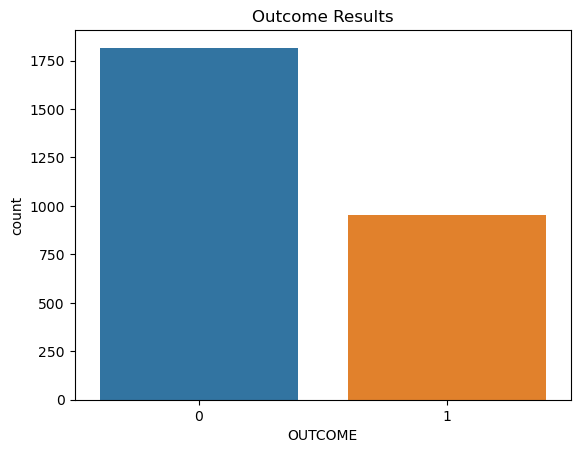

In [10]:
sns.countplot(x = df_pandas['OUTCOME'])
plt.title('Outcome Results')

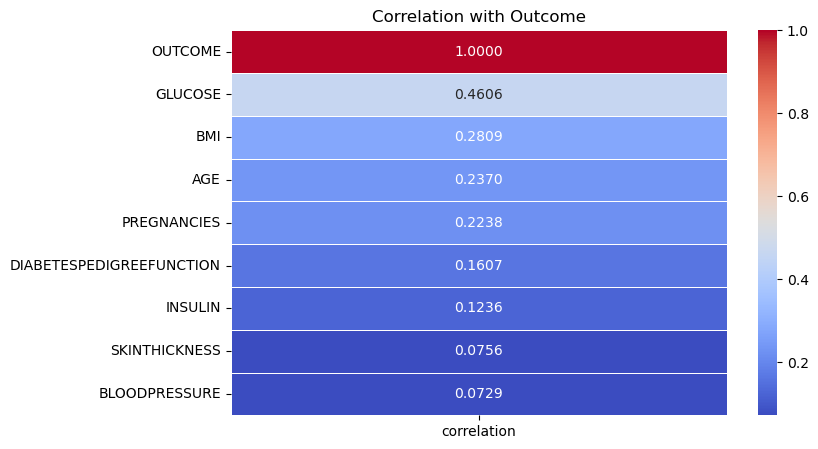

In [11]:
corr = df_pandas \
        .corrwith(df_pandas['OUTCOME'], numeric_only = True) \
        .sort_values(ascending=False)

plt.figure(figsize=(8, 5))

sns.heatmap(pd.DataFrame(corr , columns=['correlation']), annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)
plt.title('Correlation with Outcome')
plt.show()

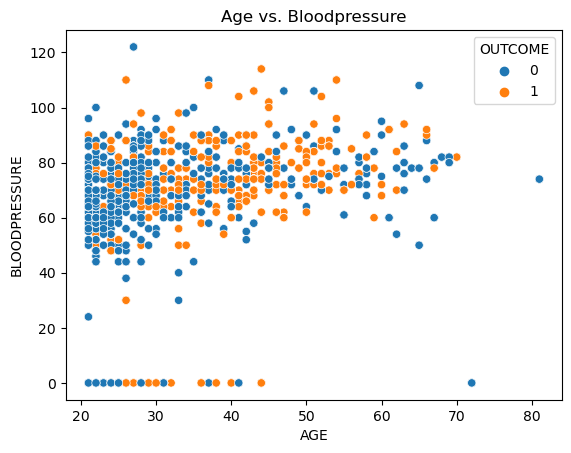

In [12]:
sns.scatterplot(data = df_pandas,
                x = "AGE", 
                y = "BLOODPRESSURE", 
                hue = "OUTCOME")
plt.title("Age vs. Bloodpressure")
plt.show()

# 5. Write cleaned data to a Snowflake table

In [13]:
session.get_current_schema()

'"SILVER"'

In [14]:

dataframe2.write.mode('overwrite').save_as_table('DIABETES_SNOWPARK_v4')


In [15]:
session.close()